In [3]:
from utils import load_config
import yaml
import os
os.chdir('../../../Interpretable-Deep-Fake-Detection/training/')
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.set_device(0)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
sys.argv = ["train.py"]
from train import init_seed, prepare_training_data, prepare_testing_data, choose_optimizer, choose_scheduler, choose_metric
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from datetime import timedelta
from detectors import DETECTOR
# from trainer.trainer import Trainer
pretrained_paths = ['/pfs/work7/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/weights/resnet34_v2_minimal/03_10_16_34_15_ckpt_best.pth']
path = "./config/detector/resnet34_bcos_v2_minimal.yaml"
additional_args = {'test_batchSize': 4,
                  'pretrained': pretrained_paths[0]
                  #'backbone_config':{}
                  }
config = load_config(path, additional_args=additional_args)

2025-03-24 09:52:04.780899: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 09:52:04.821119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 09:52:04.821148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 09:52:04.821170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 09:52:04.829803: I tensorflow/core/platform/cpu_feature_g

In [5]:
from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
import random
# init seed
# init_seed(config)

torch.manual_seed(34)
random.seed(34)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility

# prepare the testing data loader
test_data_loaders = prepare_testing_data(config)

# prepare the model (detector)
model_class = DETECTOR[config['model_name']]
model = model_class(config)
for path in pretrained_paths:
    state_dict = torch.load(path)
    # Remove "module." prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    
    model.load_state_dict(new_state_dict)
    model.cuda()#.to("cuda:0")
    print(next(model.parameters()).device)
    
    model.eval()
    # testing for all test data
    keys = test_data_loaders.keys()
    for key in keys:
        print(key)
        data_dict = test_data_loaders[key].dataset.data_dict
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]),total=len(test_data_loaders[key])):
            if i < 3:
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')  # remove the specific label
                data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
                # move data to GPU elegantly
                for key in data_dict.keys():
                    if data_dict[key]!=None:
                        data_dict[key]=data_dict[key].cuda()
                # model forward without considering gradient computation
                # print(data_dict)
                with torch.no_grad():
                    predictions = inference(model, data_dict)
                print(data_dict['label'])
                print(predictions['prob'])
            else:
                break


cuda:0
FaceForensics++


  0%|          | 3/5586 [00:00<12:01,  7.73it/s]

tensor([1, 1, 1, 0], device='cuda:0')
tensor([0.9989, 0.2248, 0.9905, 0.9993], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0.9986, 0.9999, 1.0000, 1.0000], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0.9893, 1.0000, 1.0000, 0.1019], device='cuda:0')


cpu
FaceForensics++
dict_keys(['image', 'label', 'landmark', 'mask'])
Batch of images shape: torch.Size([2, 6, 224, 224])


/pfs/data5/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/training/bcos/common.py:181: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])
1


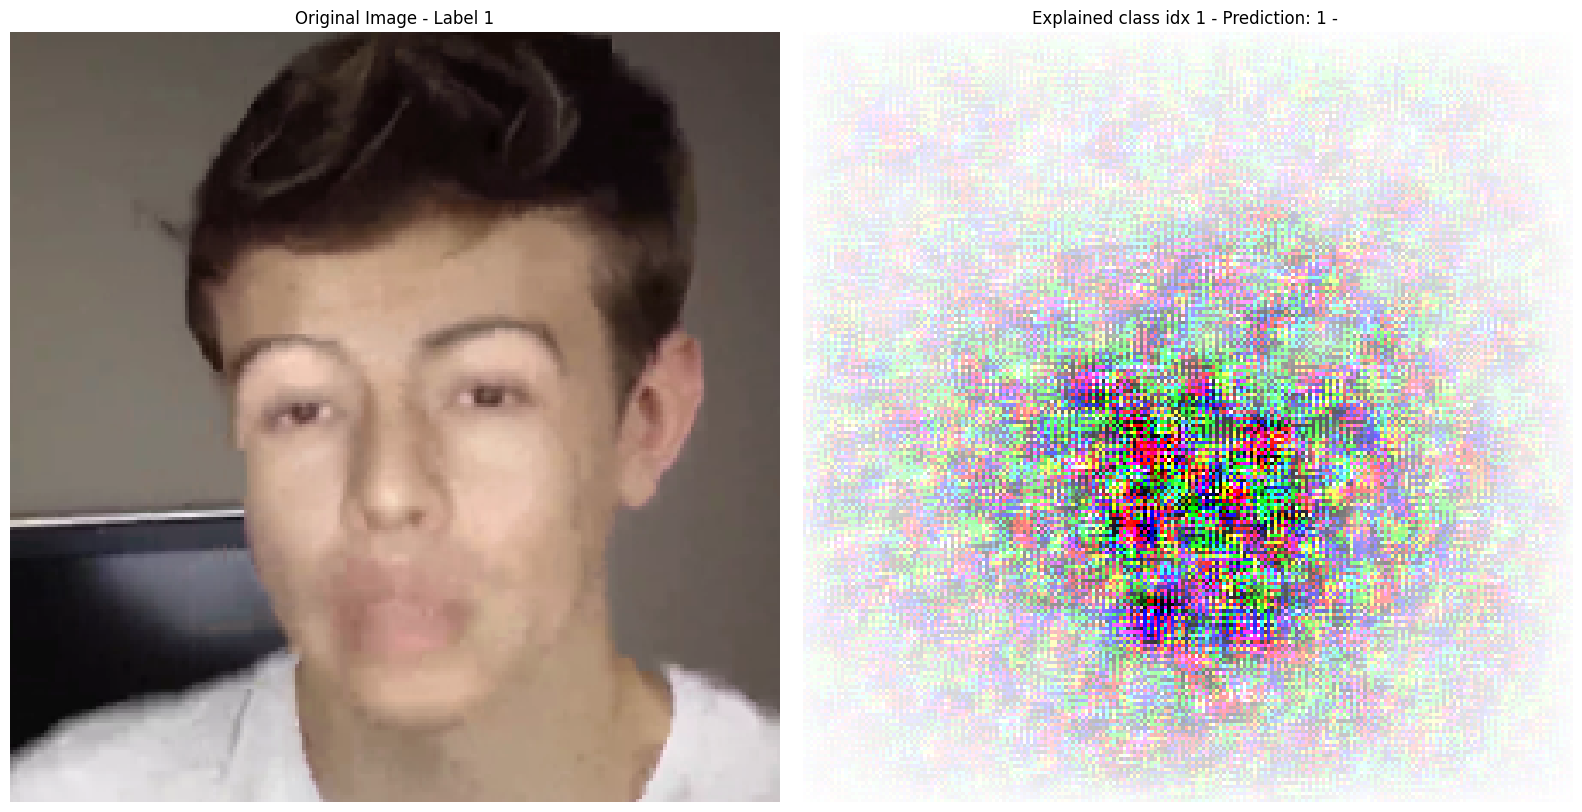

dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])
1


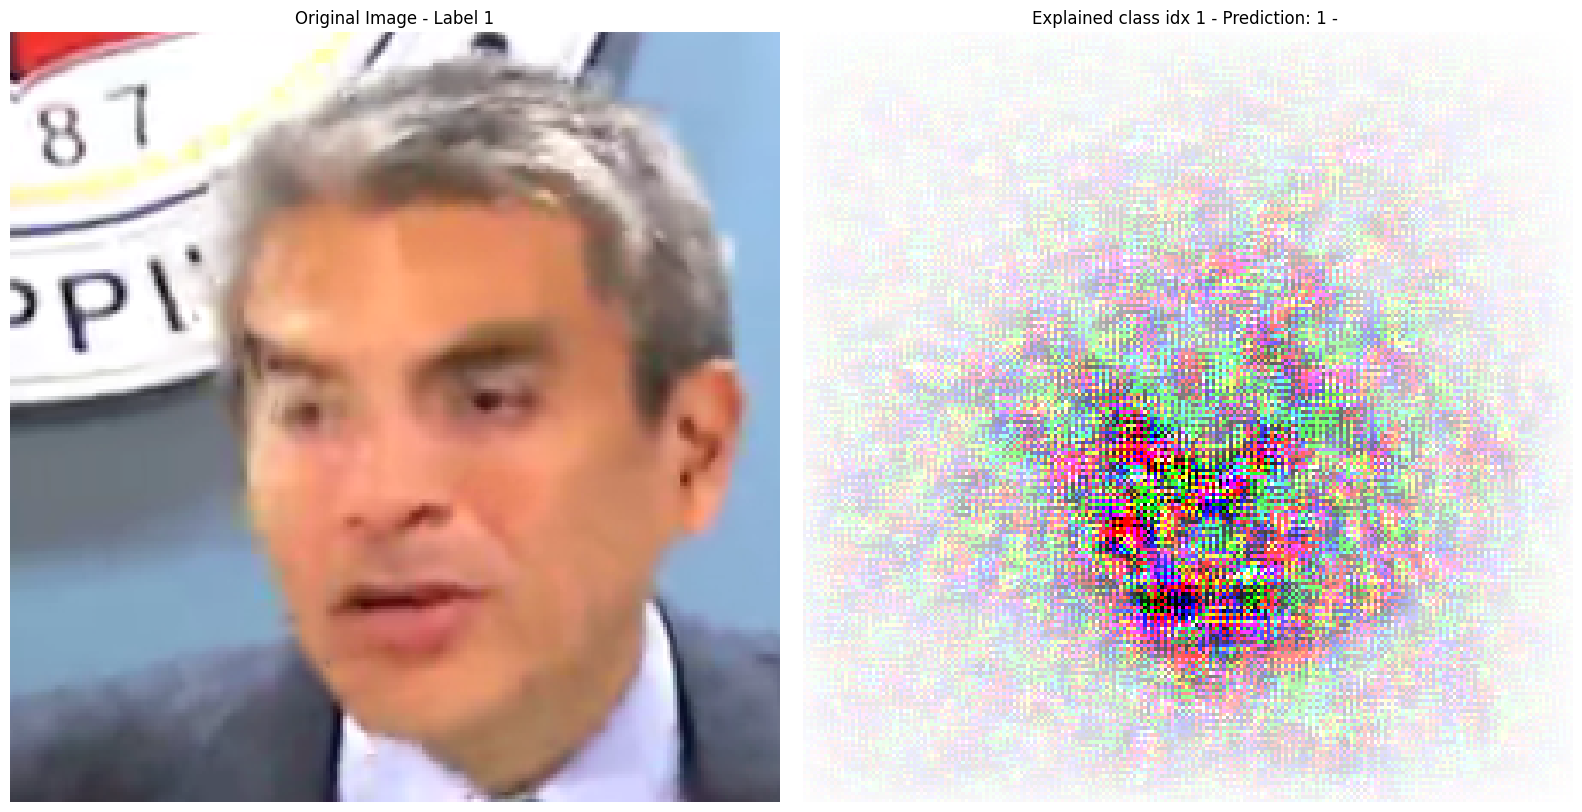

dict_keys(['image', 'label', 'landmark', 'mask'])
Batch of images shape: torch.Size([2, 6, 224, 224])
dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])
1


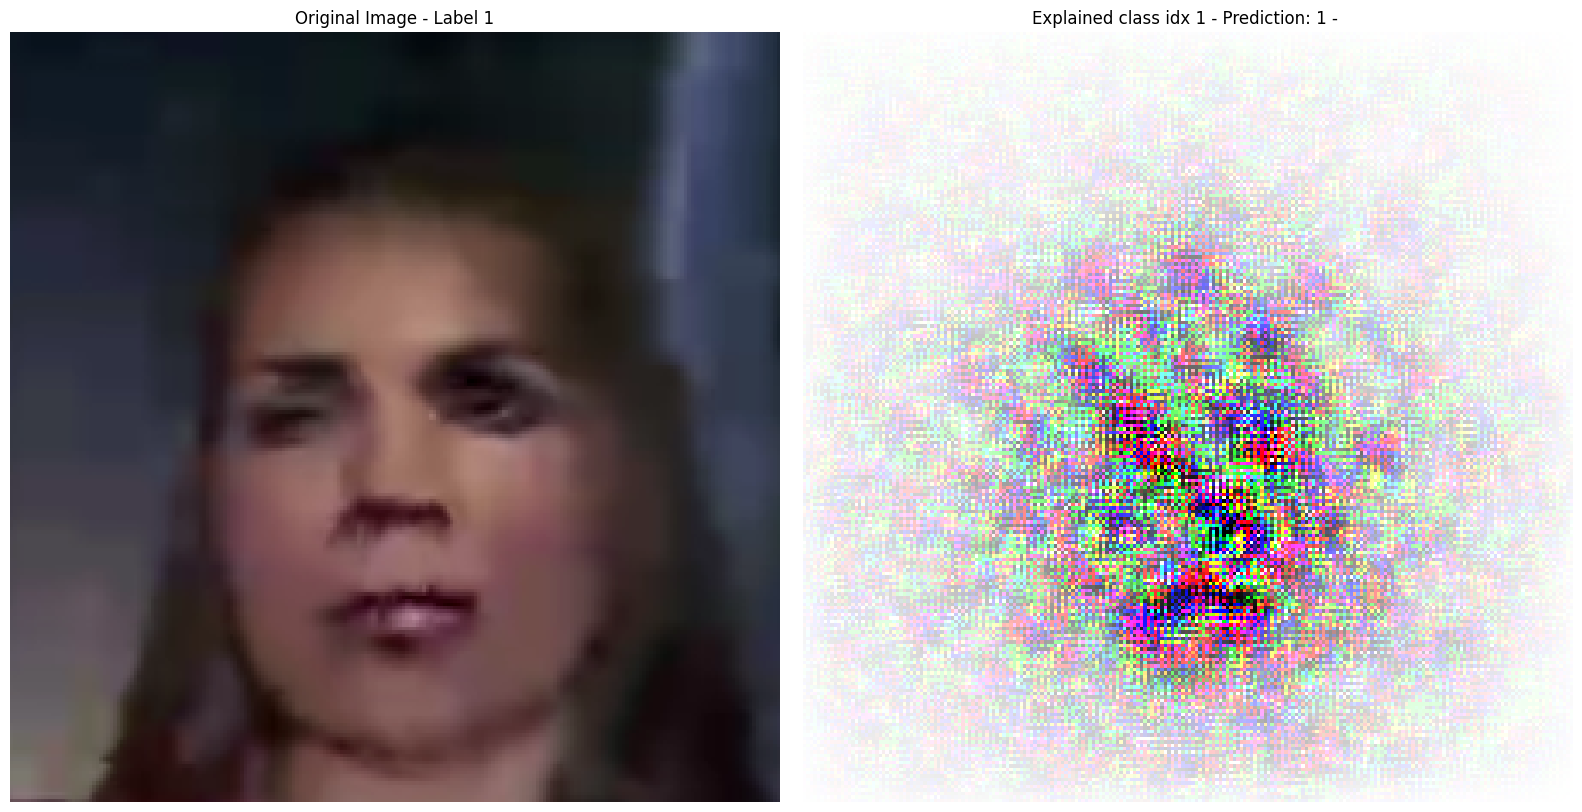

dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])
1


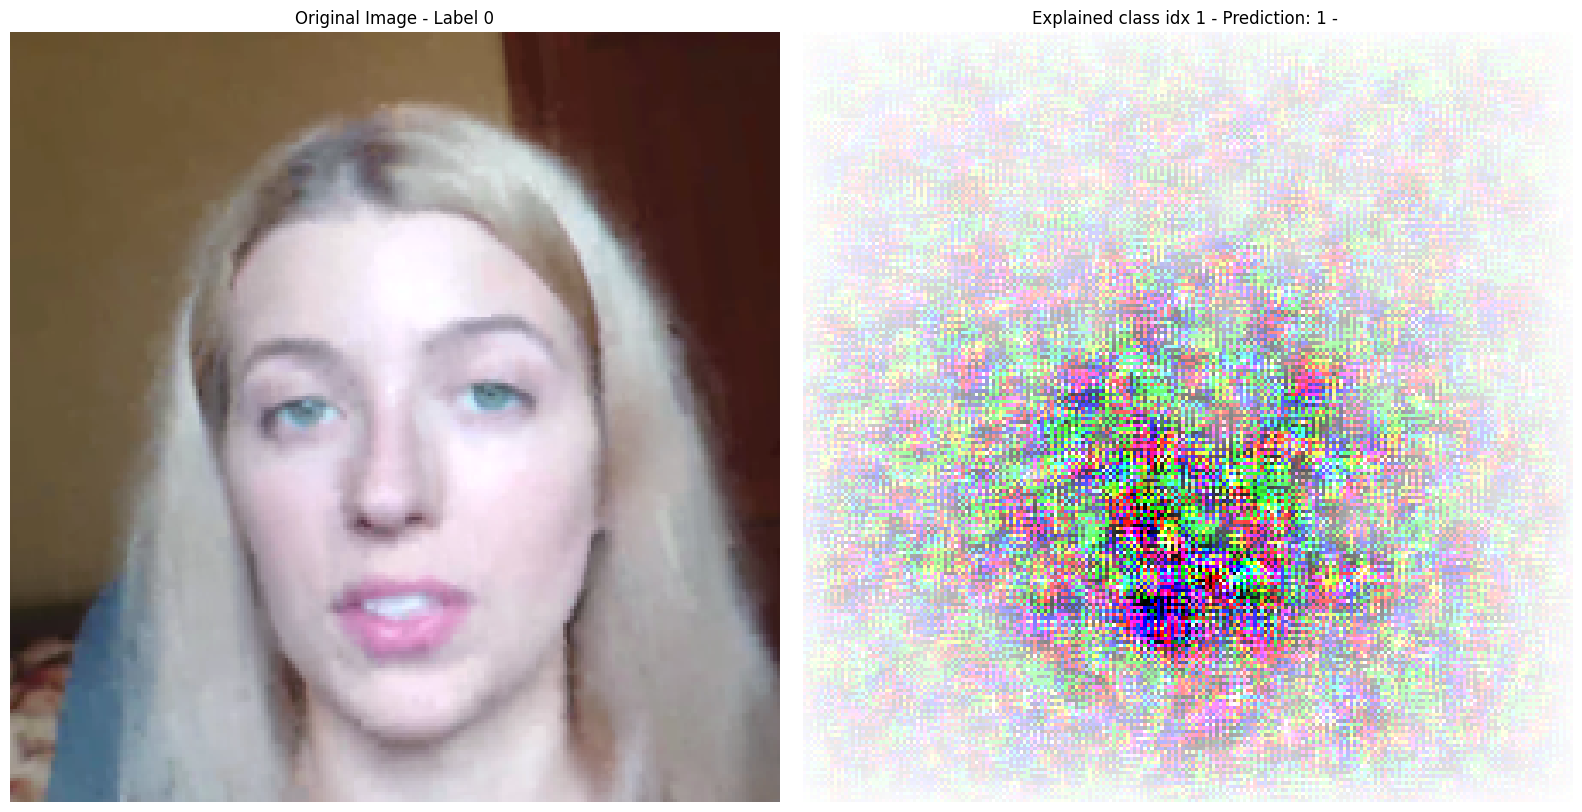

dict_keys(['image', 'label', 'landmark', 'mask'])
Batch of images shape: torch.Size([2, 6, 224, 224])
dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])
1


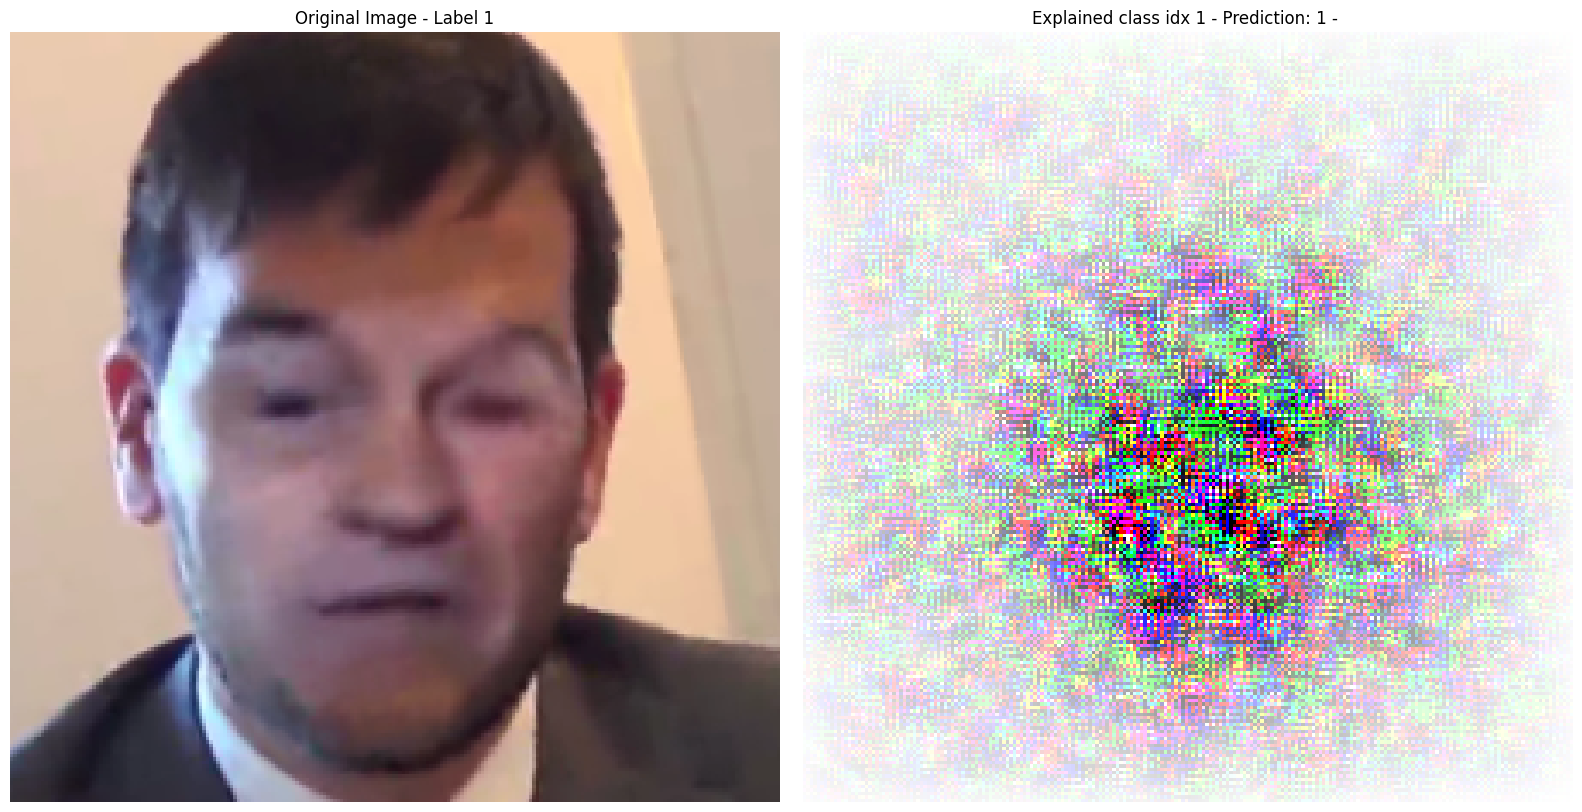

dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])
1


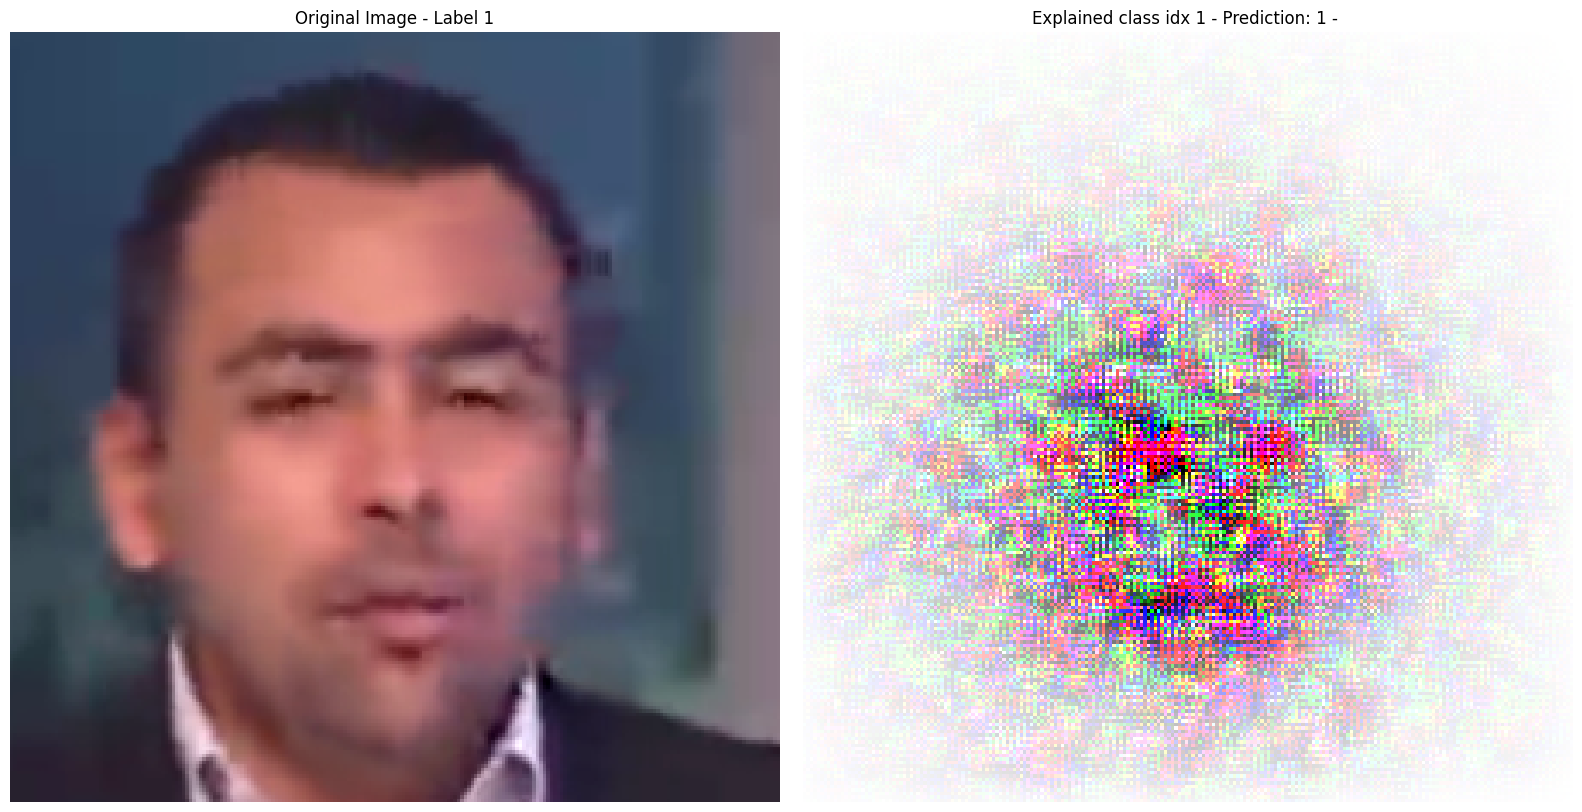

In [6]:

from bcos.interpretability import grad_to_img, to_numpy
import numpy as np
import matplotlib.pyplot as plt
from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
import random
# init seed
# init_seed(config)

torch.manual_seed(2)
random.seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility

device = torch.device("cpu")

# prepare the training data loader
# train_data_loader = prepare_training_data(config)
config['test_batchSize'] = 2
# prepare the testing data loader
test_data_loaders = prepare_testing_data(config)

# prepare the model (detector)
model_class = DETECTOR[config['model_name']]
model = model_class(config)
for path in pretrained_paths:
    state_dict = torch.load(path)
    # Remove "module." prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    
    model.load_state_dict(new_state_dict)
    model.to(device)#.cuda()
    print(next(model.parameters()).device)
    # testing for all test data
    key = list(test_data_loaders.keys())[0]
    print(key)
    for i, data_dict in enumerate(test_data_loaders[key]):#img_batch, label_batch in dataloader:
        if i<3:
            print(data_dict.keys())
            img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
    
            print(f"Batch of images shape: {img_batch.shape}")
            # device = "cpu"
            if 'label_spe' in data_dict:
                data_dict.pop('label_spe')  # remove the specific label
            data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
            # move data to GPU elegantly
            for key in data_dict.keys():
                if data_dict[key]!=None:
                    data_dict[key]=data_dict[key].to(device)#cuda()
    
            num_batches = img_batch.shape[0]
            # Iterate through each image in the batch
            for i in range(num_batches):
                img = img_batch[i].unsqueeze(0).to(device)#).cuda()  # Process a single image
                label = label_batch[i]
        
                # img = img.requires_grad_(True)

                # input_tensor = img.clone().requires_grad_()

                # # 1. Enter explanation mode
                # with model.backbone.explanation_mode():
                #     # 2. do a fwd pass
                #     out = model.backbone(input_tensor)
                
                #     # 3. bwd pass on prediction logit wrt input
                #     prediction_logit = out.max(1).values
                #     prediction_logit.backward(inputs=[input_tensor])
                
                
                # dynamic_linear_weights = input_tensor.grad
                model.backbone.eval()
                explanation = model.backbone.explain(img)
                print(explanation.keys())
                print(explanation['prediction'])
                # plt.imshow(explanation)
                # plt.imshow(explanation['explanation'])
                #plt.imshow(att, extent=(config['resolution'], 2 * config['resolution'], 0, config['resolution']))
                # 2. Create the figure with two subplots side by side
                img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)

                fig, axes = plt.subplots(1, 2, figsize=(16, 8))
                
                # 3. Plot the original image on the left subplot
                axes[0].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
                axes[0].set_title(f"Original Image - Label {label}")
                axes[0].set_xlim(0, config['resolution'])
                axes[0].set_xticks([])
                axes[0].set_yticks([])
                for spine in axes[0].spines.values():
                    spine.set_visible(False)
                
                # 4. Plot the explanation (or any relevant data) on the right subplot
                # Assuming explanation is a tensor or numpy array that you want to visualize
                # You can either directly plot the explanation or use another variable such as attention maps or gradients
                axes[1].imshow(explanation['explanation'], extent=(0, config['resolution'], 0, config['resolution']))  # Replace explanation with your actual variable
                axes[1].set_title(f"Explained class idx {explanation['explained_class_idx']} - Prediction: {explanation['prediction']} - ")
                axes[1].set_xlim(0, config['resolution'])
                axes[1].set_xticks([])
                axes[1].set_yticks([])
                for spine in axes[1].spines.values():
                    spine.set_visible(False)
                
                # 5. Display the plot
                plt.tight_layout()  # Ensures proper spacing between plots
                plt.show()
                
        else:
            break


In [7]:
# from bcos.interpretability import grad_to_img, to_numpy
# import numpy as np
# import matplotlib.pyplot as plt
# from test import test_epoch, test_one_dataset, test_epoch, inference
# from tqdm import tqdm
# import random
# # init seed
# # init_seed(config)

# torch.manual_seed(2)
# random.seed(2)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility

# device = torch.device("cpu")

# # prepare the training data loader
# # train_data_loader = prepare_training_data(config)
# config['test_batchSize'] = 2
# # prepare the testing data loader
# train_data_loader = prepare_training_data(config)

# # prepare the model (detector)
# model_class = DETECTOR[config['model_name']]
# model = model_class(config)
# for path in pretrained_paths:
#     state_dict = torch.load(path)
#     # Remove "module." prefix
#     from collections import OrderedDict
#     new_state_dict = OrderedDict()
#     for k, v in state_dict.items():
#         new_key = k.replace("module.", "")  # Remove "module." prefix
#         new_state_dict[new_key] = v
    
#     model.load_state_dict(new_state_dict)
#     model.to(device)#.cuda()
#     print(next(model.parameters()).device)
#     # testing for all test data
#     # key = list(train_data_loaders.keys())[0]
#     # print(key)
#     for i, data_dict in enumerate(train_data_loader):#img_batch, label_batch in dataloader:
#         if i<6:
#             print(data_dict.keys())
#             img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
    
#             print(f"Batch of images shape: {img_batch.shape}")
#             # device = "cpu"
#             if 'label_spe' in data_dict:
#                 data_dict.pop('label_spe')  # remove the specific label
#             data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
#             print(data_dict.keys())
#             print(data_dict['landmark'])
#             # move data to GPU elegantly
#             for key in data_dict.keys():
#                 if data_dict[key]!=None:
#                     data_dict[key]=data_dict[key].to(device)#cuda()
    
#             num_batches = img_batch.shape[0]
#             # Iterate through each image in the batch
#             for i in range(num_batches):
#                 img = img_batch[i].unsqueeze(0).to(device)#).cuda()  # Process a single image
#                 label = label_batch[i]
#                 # plt.imshow(explanation)
#                 # plt.imshow(explanation['explanation'])
#                 #plt.imshow(att, extent=(config['resolution'], 2 * config['resolution'], 0, config['resolution']))
#                 # 2. Create the figure with two subplots side by side
#                 img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)

#                 fig, axes = plt.subplots(1, 2, figsize=(16, 8))
                
#                 # 3. Plot the original image on the left subplot
#                 axes[0].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
#                 axes[0].set_title(f"Original Image - Label {label}")
#                 axes[0].set_xlim(0, config['resolution'])
#                 axes[0].set_xticks([])
#                 axes[0].set_yticks([])
#                 for spine in axes[0].spines.values():
#                     spine.set_visible(False)
                
#                 # 4. Plot the explanation (or any relevant data) on the right subplot
#                 # Assuming explanation is a tensor or numpy array that you want to visualize
#                 # You can either directly plot the explanation or use another variable such as attention maps or gradients
#                 axes[1].imshow(explanation['explanation'], extent=(0, config['resolution'], 0, config['resolution']))  # Replace explanation with your actual variable
#                 axes[1].set_title(f"Explained class idx {explanation['explained_class_idx']} - Prediction: {explanation['prediction']} - ")
#                 axes[1].set_xlim(0, config['resolution'])
#                 axes[1].set_xticks([])
#                 axes[1].set_yticks([])
#                 for spine in axes[1].spines.values():
#                     spine.set_visible(False)
                
#                 # 5. Display the plot
#                 plt.tight_layout()  # Ensures proper spacing between plots
#                 plt.show()
                
#         else:
#             break

